<a href="https://colab.research.google.com/github/AhmedRezaShams/Python/blob/main/MobileNet_baseline_Reza.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
from tensorflow.keras.utils import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from tensorflow.keras.optimizers.legacy import Adam, SGD, RMSprop
import tensorflow as tf

In [ ]:
!pip install -U -q PyDrive  #py framework
from pydrive.auth import GoogleAuth 
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client  import GoogleCredentials  #clint library
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
fid = drive.ListFile({'q':"title='fabric_defect.zip'"}).GetList()[0]['id'] #is a method call in the Google Drive API for Python that lists all the files in the current user's Google Drive that match a certain query.
f = drive.CreateFile({'id': fid})
f.GetContentFile('fabric_defect.zip')
f.keys()
!unzip fabric_defect.zip


Archive:  fabric_defect.zip
   creating: Fabric defect/
   creating: Fabric defect/test/
   creating: Fabric defect/test/hole/
  inflating: Fabric defect/test/hole/1.jpg  
  inflating: Fabric defect/test/hole/10.jpg  
  inflating: Fabric defect/test/hole/10_processed (1).jpg  
  inflating: Fabric defect/test/hole/10_processed (2).jpg  
  inflating: Fabric defect/test/hole/10_processed (3).jpg  
  inflating: Fabric defect/test/hole/11.jpg  
  inflating: Fabric defect/test/hole/11_processed (1).jpg  
  inflating: Fabric defect/test/hole/11_processed (2).jpg  
  inflating: Fabric defect/test/hole/11_processed (3).jpg  
  inflating: Fabric defect/test/hole/12.jpg  
  inflating: Fabric defect/test/hole/12_processed (1).jpg  
  inflating: Fabric defect/test/hole/12_processed (2).jpg  
  inflating: Fabric defect/test/hole/12_processed (3).jpg  
  inflating: Fabric defect/test/hole/13.jpg  
  inflating: Fabric defect/test/hole/13_processed (1).jpg  
  inflating: Fabric defect/test/hole/13_proc

In [ ]:
gpus = tf.config.list_logical_devices('GPU') 
stg=tf.distribute.MirroredStrategy(gpus)

In [ ]:
folder_path = "/content/Fabric defect" 
# folder_path = "../input/face-expression-recognition-dataset/images/"
# validation_folder_path = "../input/face-expression-recognition-dataset/images/"

In [ ]:
import cv2
import os
from tqdm import tqdm

folder_dir = '/content/Fabric defect/train'
SIZE = (48,48) 
DOWNSAMPLE_RATIO = 4
JPEG_QUALITY = 80

# get the total number of files to process
total_files = sum(len(files) for _, _, files in os.walk(folder_dir))

# use tqdm to display a progress bar
with tqdm(total=total_files, desc="Processing Images") as pbar:
    for folder in os.listdir(folder_dir):
        for file in os.listdir(os.path.join(folder_dir, folder)):
            if file.endswith("jpg"):
                image_path = os.path.join(folder_dir, folder, file)
                img = cv2.imread(image_path)
                img_resized = cv2.resize(img, (SIZE))
                cv2.imwrite(image_path, img_resized)
                pbar.update(1) # increment the progress bar
            else:
                continue


Processing Images: 100%|██████████| 666/666 [00:00<00:00, 2305.99it/s]


In [ ]:
'''
expression = 'happy'
plt.style.use('dark_background')
plt.figure(figsize=(12, 12))
for i in range(1, 10):
    plt.subplot(3, 3, i)
    img = load_img(folder_path + "train/" + expression + "/" + os.listdir(folder_path + "train/" + expression)[i], target_size=SIZE)
    plt.imshow(img)  
plt.show()
'''

'\nexpression = \'happy\'\nplt.style.use(\'dark_background\')\nplt.figure(figsize=(12, 12))\nfor i in range(1, 10):\n    plt.subplot(3, 3, i)\n    img = load_img(folder_path + "train/" + expression + "/" + os.listdir(folder_path + "train/" + expression)[i], target_size=SIZE)\n    plt.imshow(img)  \nplt.show()\n'

In [ ]:
batch_size = 32
picture_size = SIZE
datagen_train = ImageDataGenerator(rotation_range=.5, 
                                    width_shift_range=0.2, 
                                    height_shift_range=0.2, 
                                    zoom_range=0.2, 
                                    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input 
                                )

datagen_val = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input )

train_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range=.5,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    zoom_range=0.2,
                                    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
#train_dir = '/content/Fabric defect/train';
#val_dir = '/content/Fabric defect/validation';
train_generator = train_datagen.flow_from_directory(folder_dir,
                                                    target_size=(picture_size),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

validation_set = test_datagen.flow_from_directory(folder_dir,
                                                        target_size=(picture_size),
                                                        batch_size=batch_size,
                                                        class_mode='categorical')

Found 666 images belonging to 4 classes.
Found 666 images belonging to 4 classes.


In [ ]:

from tensorflow.keras.optimizers import Adam,SGD,RMSprop
from tensorflow.keras.optimizers import RMSprop,SGD,Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


no_of_classes = 4

with stg.scope():
    base_model = tf.keras.applications.MobileNetV2(input_shape=(48,48,3),
                                                   include_top=False,
                                                   weights=None)

    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(no_of_classes, activation='softmax'))

    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(lr=0.001),
        metrics=['accuracy'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_48 (Functi  (None, 2, 2, 1280)       2257984   
 onal)                                                           
                                                                 
 global_average_pooling2d_6   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_18 (Dense)            (None, 512)               655872    
                                                                 
 dense_19 (Dense)            (None, 128)               65664     
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_20 (Dense)            (None, 4)                

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',
                                patience=3,
                                verbose=1,
                                restore_best_weights=True)

lr_scheduler = ReduceLROnPlateau(monitor='val_loss',
                                factor=0.1,
                                patience=2,
                                verbose=1)

callbacks = [early_stopping, lr_scheduler]

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.00001), metrics=['accuracy'])
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.n // batch_size,
                    epochs=30,
                    validation_data=validation_set,
                    validation_steps=validation_set.n // batch_size,
                    callbacks=callbacks)

Epoch 1/30
20/20 [==============================] - 49s 774ms/step - loss: 1.3102 - accuracy: 0.4448 - val_loss: 1.3843 - val_accuracy: 0.4234 - lr: 0.0010
Epoch 2/30
20/20 [==============================] - 14s 683ms/step - loss: 1.0415 - accuracy: 0.5268 - val_loss: 1.3822 - val_accuracy: 0.4219 - lr: 0.0010
Epoch 3/30
20/20 [==============================] - 12s 609ms/step - loss: 0.9951 - accuracy: 0.5300 - val_loss: 1.3819 - val_accuracy: 0.4219 - lr: 0.0010
Epoch 4/30
20/20 [==============================] - 12s 604ms/step - loss: 0.9748 - accuracy: 0.5363 - val_loss: 1.3821 - val_accuracy: 0.4219 - lr: 0.0010
Epoch 5/30
20/20 [==============================] - 13s 669ms/step - loss: 0.9146 - accuracy: 0.5505 - val_loss: 1.3796 - val_accuracy: 0.4187 - lr: 0.0010
Epoch 6/30
20/20 [==============================] - 13s 672ms/step - loss: 0.9270 - accuracy: 0.5584 - val_loss: 1.3780 - val_accuracy: 0.4172 - lr: 0.0010
Epoch 7/30
20/20 [==============================] - 13s 681ms/st

In [ ]:
test_loss, test_acc = model.evaluate(validation_set)
print('Test accuracy:', test_acc)

21/21 [==============================] - 2s 74ms/step - loss: 1.3747 - accuracy: 0.4219
Test accuracy: 0.42192190885543823


In [ ]:
model.save('/kaggle/working/my_model_emo.h5')

0 = Vertical
1 = Horizontal
2 = Hole
3 = Lines
1/1 [==============================] - 0s 122ms/step


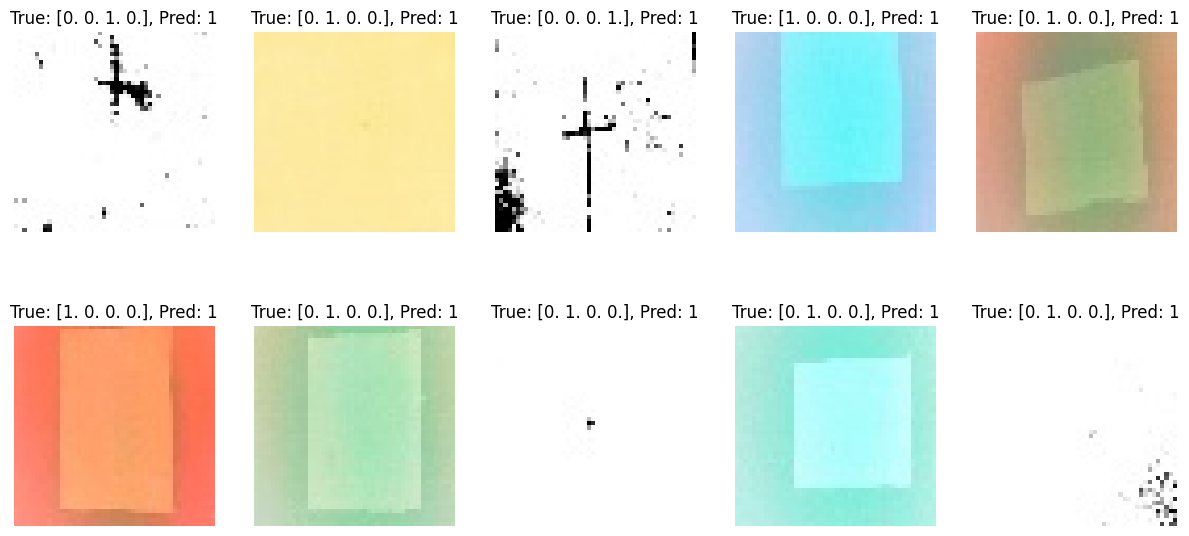

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
e = ['Vertical','Horizontal','Hole','Lines']
for i in range(len(e)):
    print(i,"=",e[i])
# Get a batch of 10 random images from the test set
test_batch = validation_set.next()
images = test_batch[0][:10]
true_labels = test_batch[1][:10]

# Make predictions using the trained model
pred_probs = model.predict(images)
pred_labels = np.argmax(pred_probs, axis=1)

# Plot the images with their true and predicted labels
fig, axs = plt.subplots(2, 5, figsize=(15, 7))
axs = axs.flatten()

for i in range(len(images)):
    # Rescale the pixel values from [0, 1] to [0, 255] and convert to integers
    img = (images[i] * 255).astype(np.uint8)
    # Invert the pixel values
    img = 255 - img
    axs[i].imshow(img)
    axs[i].set_title(f'True: {true_labels[i]}, Pred: {pred_labels[i]}')
    axs[i].axis('off')

plt.show()

